In [83]:
#This is my pretrained and finetuned BERT for generation of words on a partially masked corpus of text i.e. Twitch Data

In [84]:
#Utilizing Hugging Face
#https://huggingface.co/docs/transformers/quicktour

#Refs
#https://towardsdatascience.com/how-to-use-bert-from-the-hugging-face-transformer-library-d373a22b0209

**Install Requirements**

In [85]:
# %pip install transformers datasets
#%pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu${CUDA_VERSION}/torch_stable.html

# %from transformers import EncoderDecoderModel, BertTokenizer
#%pip freeze requirements.txt
# %pip install matplotlib
# %pip install numpy



**Imports**

In [86]:
import transformers
import torch
import os
import pandas as pd
import pickle as pkl
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup


device = torch.device("cpu")    # use CPU



**Loading Data**

In [87]:
#Load Raw Data from StreamerData folder
#- Take certain number of files from data folder to use for generation

#Set this to the path of your data
folder_path = 'C:/Users/anish/Projects/twitchBot/streamerdata'

numFiles = 2

data = []

for i, file in enumerate(os.listdir(folder_path)):
    print("Adding file:", file)
    if i == numFiles - 1:
        break  
    with open(os.path.join(folder_path, file), 'rb') as f:
        curr_file = pkl.load(f)
        data.append(curr_file)

all_df = pd.concat(data, axis = 0)

Adding file: admiralbahroo.pkl
Adding file: admiralbulldog.pkl


In [88]:
#Display all_data
display(all_df.head())

#Print data columns
print([i for i in all_df.columns])

#Print size of data
print("Num Rows:", len(all_df))
print("Num Cols:", len(all_df.columns))


,body,channel_id,commenter_id,commenter_type,created_at,fragments,offset,updated_at,video_id
0,STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...,40972890,110969182,user,2018-06-24T17:07:43.067Z,"[{'text': 'STILL LATE STRIMMER IS A BAKA '}, {...",4.367,2018-06-24T17:07:43.067Z,277073045
1,NOT LIVE rooREE rooREE rooREE,40972890,109856709,user,2018-06-24T17:07:43.168Z,"[{'text': 'NOT LIVE '}, {'emoticon_id': '90487...",4.468,2018-06-24T17:07:43.168Z,277073045
2,rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...,40972890,56159955,user,2018-06-24T17:07:44.631Z,"[{'emoticon_id': '904818'}, {'text': ' BAHROOr...",5.931,2018-06-24T17:07:44.631Z,277073045
3,See,40972890,78678476,user,2018-06-24T17:07:45.602Z,[{'text': 'See'}],6.902,2018-06-24T17:07:45.602Z,277073045
4,rooPog,40972890,30898708,user,2018-06-24T17:07:45.802Z,[{'emoticon_id': '904866'}],7.102,2018-06-24T17:07:45.802Z,277073045


['body', 'channel_id', 'commenter_id', 'commenter_type', 'created_at', 'fragments', 'offset', 'updated_at', 'video_id']
Num Rows: 2722109
Num Cols: 9


**Data Preprocessing**

In [89]:
#Filter Data Frame by Strings that are longer than 3 -> Allow for masking
long_df = all_df[all_df['body'].apply(lambda x: len(x.split(' '))) > 3]

#Use small dataframe for testing efficiency's sake
long_df = long_df.iloc[:100]
print("Number of Rows:", len(long_df))

#Replace certain words with Mask token '[MASK]'
masked_arr = long_df.body.tolist()
for i in range(len(masked_arr)):

    add_mask = masked_arr[i].split(" ")
    mask_index = random.randint(0, len(add_mask) - 1)
    add_mask[mask_index] = '[MASK]'
    masked_arr[i] = " ".join(add_mask)


long_df['masked'] = masked_arr

display(long_df['masked'].head())

Number of Rows: 100


0    STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER...
1                        NOT LIVE rooREE [MASK] rooREE
2    rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooB...
7           rooHappy [MASK] rooHappy rooHappy rooHappy
8    rooREE LATE rooREE LATE rooREE LATE rooREE LAT...
Name: masked, dtype: object

**Tokenizing**

In [90]:
#Taking the processed data and tokenizing it for the BERT model
#Using the bert-base-uncased model"
#- 110M params
#- English
#- Trained on BookCorpus, dataset consisting of 11,038 unpublished books and English Wikipedia
#- Vocabulary size of 30,000
#- inputs are of the form [CLS] Sentence A [SEP] Sentence B [SEP]


model_pretrained = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(model_pretrained)
model = transformers.BertForMaskedLM.from_pretrained(model_pretrained, return_dict = True, output_hidden_states=True)
long_df['tokens'] = [tokenizer.encode_plus(text, return_tensors = "pt") for text in long_df['masked']]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Fine Tuning**

In [91]:
class MaskedLMHead(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = torch.nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.decoder = torch.nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.bias = torch.nn.Parameter(torch.zeros(config.vocab_size))

    def forward(self, features):
        x = self.dense(features)
        x = torch.nn.functional.gelu(x)
        x = self.layer_norm(x)
        x = self.decoder(x) + self.bias
        return x


In [92]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


In [93]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Tokenize the text
        tokenized_text = self.tokenizer.encode_plus(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )
        return tokenized_text['input_ids'], tokenized_text['attention_mask']


In [94]:
#list(long_df['masked'])

['STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka STRIMMER [MASK] A BAKA rooBaka',
 'NOT LIVE rooREE [MASK] rooREE',
 'rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka [MASK] BAHROO',
 'rooHappy [MASK] rooHappy rooHappy rooHappy',
 'rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE [MASK] rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE',
 'roo3 [MASK] roo3 roo3',
 'rooCop [MASK] rooCop rooCop rooCop',
 'LIVE POGGERS LIVE POGGERS LIVE POGGERS LIVE POGGERS LIVE POGGERS LIVE POGGERS [MASK] POGGERS LIVE POGGERS',
 'rooBaka BAHROO rooBaka [MASK] rooBaka BAHROO rooBaka BAHROO rooBaka BAHROO rooBaka BAHROO rooBaka BAHROO',
 'rooHappy rooHappy rooHappy rooHappy

In [95]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   8320 KiB |   7418 MiB |  13842 MiB |  13833 MiB |\n|       from large pool |   8320 KiB |   7322 MiB |  13745 MiB |  13737 MiB |\n|       from small pool |      0 KiB |     95 MiB |     96 MiB |     96 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   8320 KiB |   7418 MiB |  13842 MiB |  13833 MiB |\n|       from large pool |   8320 KiB |   7322 MiB |

In [97]:

train_dataset = TextDataset(list(long_df['masked']), tokenizer)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
mlm_head = MaskedLMHead(model.config).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
# Define the scheduler
num_training_steps = len(train_loader) * 3
num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

model.to(device)

for epoch in range(1):
    print('Epoch:', epoch+1)
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids, attention_mask, *_  = batch
        input_ids, attention_mask = input_ids.view(-1, input_ids.size(-1)), attention_mask.view(-1, attention_mask.size(-1))
        outputs = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), labels=input_ids.to(device))
        logits = mlm_head(outputs.hidden_states[-1]).to(device)
        loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1))
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print('Avg Loss:', avg_loss)


Epoch: 1


100%|██████████| 100/100 [06:57<00:00,  4.18s/it]

Avg Loss: 1.9094887848198414


**Get Predictions**

In [98]:
predictions = []
numberPredsPer = 10
for text in long_df['masked']:
    input = tokenizer.encode_plus(text, return_tensors = "pt")
    mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
    output = model(**input)
    logits = output.logits
    softmax = F.softmax(logits, dim = -1)
    mask_word = softmax[0, mask_index, :]
    top_10 = torch.topk(mask_word, numberPredsPer, dim = 1)[1][0]
    curr_preds = []
    for token in top_10:
        word = tokenizer.decode([token])
        new_sentence = text.replace(tokenizer.mask_token, word)
        curr_preds.append(new_sentence)
    predictions.append(curr_preds)


long_df['predictions'] = predictions

#Display your Predictions vs. Actual!
for row in range(len(long_df.body[:5])):
    print(row, "Masked:", long_df.iloc[row].body)
    print(row, "Predicted:", long_df.iloc[row].predictions[0])

0 Masked: STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka
0 Predicted: STILL LATE STRIMMER IS A BAKA rooBaka STRIMMER IS A BAKA rooBaka STRIMMER american A BAKA rooBaka
1 Masked: NOT LIVE rooREE rooREE rooREE
1 Predicted: NOT LIVE rooREE american rooREE
2 Masked: rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROO
2 Predicted: rooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka BAHROOrooBaka ##ee BAHROO
3 Masked: rooHappy rooHappy rooHappy rooHappy rooHappy
3 Predicted: rooHappy american rooHappy rooHappy rooHappy
4 Masked: rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE LATE rooREE 

**Loss Metric**

In [99]:
##Using Cosine Similarity as the metric of comparison

def cosine_similarity(a, b):
    return F.cosine_similarity(a, b, dim=1).item()

#Calculate similarity over entire data set
similarities = []
for i in range(len(long_df.body)):
    with torch.no_grad():
        original_embedding = model(input_ids=long_df.iloc[i].tokens["input_ids"]).hidden_states[-1].mean(dim=1)
        predicted_embedding = model(input_ids=tokenizer.encode_plus(long_df.iloc[i].predictions[0], return_tensors='pt')['input_ids']).hidden_states[-1].mean(dim=1)

    similarity = cosine_similarity(original_embedding, predicted_embedding)
    similarities.append(similarity)
print("Cosine similarity:", sum(similarities) / len(similarities))

Cosine similarity: 0.9893114876747131


Text(0.5, 0, 'Sentence #')

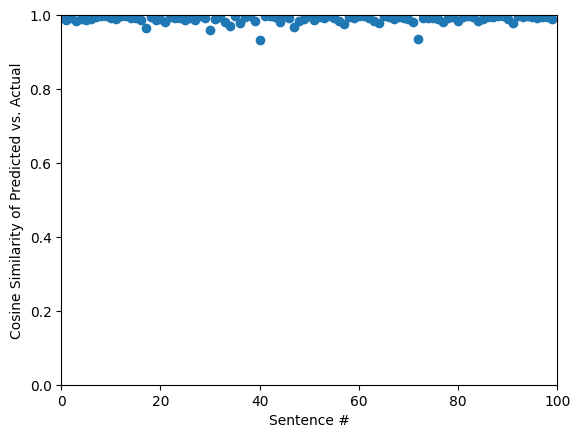

In [100]:
#Display your results!
plt.scatter(range(len(similarities)), similarities)
plt.xlim(0, len(similarities))
plt.ylim(0, 1)
plt.ylabel("Cosine Similarity of Predicted vs. Actual")
plt.xlabel("Sentence #")

** Alternate Methodolgy of Calling Hugging Face Model **

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("The quick brown fox jumps over the lazy [MASK].")